<a href="https://colab.research.google.com/github/xthimylJ/daily-practice/blob/main/pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.8.0+cu126
torchvision version: 0.23.0+cu126


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Loading fashion mnist

In [3]:
# set up training and test data
train_data = datasets.FashionMNIST(

    root="data",
    train = True,
    download= True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 189kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.49MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.1MB/s]


In [4]:
# see first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
# what's the shape of the image?
image.shape

torch.Size([1, 28, 28])

In [6]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Image shape: torch.Size([1, 28, 28])


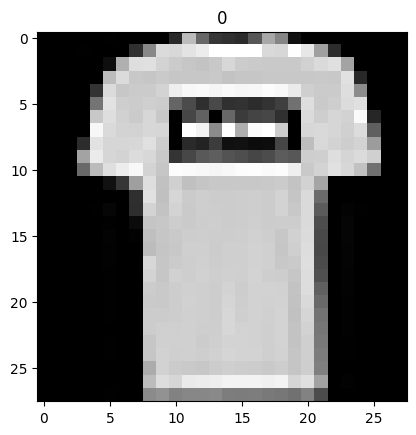

In [7]:
# visualizing data
image, item = train_data[1]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray")
plt.title(item)
plt.show()

## Batching

In [8]:
# prepare data loader
from torch.utils.data import DataLoader

# set up batch size
BATCH_SIZE = 32
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## CNN Model class

In [20]:
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.conv import Conv2d
# building model class

class CNN_Model(nn.Module):
    def __init__(self, in_channels: int, num_kernels: int, num_classes:int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_kernels,
                      kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=num_kernels, out_channels=num_kernels,
                      kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_kernels, num_kernels, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=num_kernels, out_features=num_classes)


        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)

        x = self.block_2(x)

        x = self.classifier(x)

        return x


### investingating `nn.Conv2d()`, `nn.MaxPool2d()`, `nn.Flatten()`

In [18]:
# let's simulate an image
torch.manual_seed(67)
ims = torch.randn(size=(32, 3, 64, 64))
single_im = ims[0]

In [11]:
single_im

tensor([[[-1.0390, -0.4298,  1.5251,  ...,  0.2531, -0.7321,  0.8683],
         [ 1.0003,  0.9451, -0.4444,  ..., -0.5642,  1.1278, -0.1120],
         [-0.1713,  0.3672,  0.2926,  ..., -1.0712, -0.7089,  0.1219],
         ...,
         [ 1.3515, -0.8106, -1.0373,  ..., -1.8308, -0.2564, -1.3358],
         [ 0.5334, -1.5775, -1.0026,  ...,  0.9909, -0.9383, -0.0564],
         [ 1.3804,  1.6963, -0.8366,  ..., -0.5896, -0.4239,  0.5474]],

        [[-0.7424, -1.8342,  0.7664,  ..., -0.4292,  1.2102,  2.0286],
         [-0.9743, -0.3558, -0.4349,  ...,  1.2493, -0.7460, -0.4511],
         [-0.6673, -1.0916,  1.0894,  ..., -1.6091,  0.2464,  1.0197],
         ...,
         [ 0.1128, -1.2200,  0.0147,  ...,  0.4687,  0.2372, -0.8921],
         [-0.6231,  1.5959, -0.6827,  ...,  0.5619,  0.0682, -0.7802],
         [ 0.7348, -0.6653, -2.6057,  ...,  0.6399,  0.1963, -0.3861]],

        [[ 0.7340,  1.6606, -1.0199,  ...,  0.1618,  1.5866, -0.6990],
         [ 2.2278,  0.2638,  0.4290,  ...,  0

In [12]:
# breaking down nn.Conv2d()
conv_layer = nn.Conv2d(in_channels=3, out_channels=10,kernel_size=3,padding=1,stride=1)
conv_layer

Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [13]:
single_im = single_im.unsqueeze(0)
single_im.shape

torch.Size([1, 3, 64, 64])

In [14]:
conv_single_im=conv_layer(single_im)

In [15]:
# let's see the shape of "conv_single_im"
conv_single_im.shape

torch.Size([1, 10, 64, 64])

In [16]:
# going through nn.MaxPool2d()
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
maxpooled_conv_single_im = maxpool(conv_single_im)
print(maxpooled_conv_single_im.shape)

torch.Size([1, 10, 32, 32])


In [17]:
im1 = train_data[3]

## Training the model

In [23]:
# instantiating the model class
model = CNN_Model(in_channels=1, num_kernels=10, num_classes=10).to(device)

In [24]:
model

CNN_Model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [25]:
# setting up a loss function, optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(67)
torch.cuda.manual_seed(67)

# to measure time
